# PART 2: Comparative Analysis
Utilize AI and ML models along with Prompt Engineering to analyze and compare the content.
1. Preprocessing - Clean and normalize the text data 
2. Classify Articles by Industry - Use large language model such as facebook/bart-large-mnli to classify the articles into specific industries.
3. Extract Themes, Topics, or Keywords - Use facebook/bart-large-mnli to identify the key themes, recurring topics, or significant keywords from the articles.
4. Cluster Themes
3. Vectorize the articles using embeddings.
4. Apply clustering to group similar themes.
5. Link each cluster back to its source articles to ensure traceability.

## Preprocessing
1. Combine content and pdf_content for analysis.
2. Preprocessed the text data to apply Remove special characters and digits, Tokenization, Remove stopwords, Lemmatization.
3. REmove empty text after preprocessing.

In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

df = pd.read_csv('/kaggle/input/kpmg-insights-full/kpmg_insights_full.csv')

df['full_text'] = df['content'].fillna('') + ' ' + df['pdf_content'].fillna('')

def preprocess_text(text):
    if not isinstance(text, str) or not text.strip():
        return ''
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['cleaned_text'] = df['full_text'].apply(preprocess_text)

df = df[df['cleaned_text'].str.strip() != '']

df.to_csv('/kaggle/working/preprocessed_kpmg_data.csv', index=False)
print("Preprocessing complete. Data saved to preprocessed_kpmg_data.csv")
print(f"Total articles after preprocessing: {len(df)}")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Preprocessing complete. Data saved to preprocessed_kpmg_data.csv
Total articles after preprocessing: 400


## Industry Classification
1. Initialize zero-shot classification pipeline include llm model such as facebook/bart-large-mnli.
2. Define Candidate industries based on KPMG content.

In [2]:
import pandas as pd
from transformers import pipeline
import torch

df = pd.read_csv('/kaggle/working/preprocessed_kpmg_data.csv')

industry_classifier = pipeline(
    'zero-shot-classification',
    model='facebook/bart-large-mnli',
    device=0 if torch.cuda.is_available() else -1
)

candidate_industries = [
    'Taxation',
    'Financial Services',
    'Technology',
    'Venture Capital',
    'Sustainability',
    'Immigration',
    'Trade and Tariffs',
    'Family Business',
    'Regulatory Compliance',
    'Digital Transformation'
]

def classify_industry(text):
    if not isinstance(text, str) or not text.strip():
        return 'Unknown'

    result = industry_classifier(text[:512], candidate_labels=candidate_industries, multi_label=False)
    return result['labels'][0]

df['industry'] = df['cleaned_text'].apply(classify_industry)

df.to_csv('/kaggle/working/classified_kpmg_data.csv', index=False)
print("Industry classification complete. Data saved to classified_kpmg_data.csv")
print("\nIndustry Distribution:")
print(df['industry'].value_counts())

2025-04-20 09:56:21.479219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745142981.938621      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745142982.055018      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Industry classification complete. Data saved to classified_kpmg_data.csv

Industry Distribution:
industry
Sustainability            107
Technology                 89
Financial Services         48
Taxation                   42
Regulatory Compliance      39
Digital Transformation     26
Venture Capital            18
Family Business            15
Immigration                12
Trade and Tariffs           4
Name: count, dtype: int64


## Theme Extraction
1. building a BERTopic pipeline.
2. Transformer embeddings (via MiniLM) to represent text meaningfully.
3. Clustering and topic extraction to identify distinct themes in the documents.
4. Add topic assignments to dataframe.

In [5]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

df = pd.read_csv('/kaggle/working/classified_kpmg_data.csv')

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

topic_model = BERTopic(
    embedding_model=embedding_model,
    min_topic_size=5,
    nr_topics='auto',
    verbose=True
)

topics, _ = topic_model.fit_transform(df['cleaned_text'].tolist())

df['topic'] = topics

topic_info = topic_model.get_topic_info()

def get_topic_keywords(topic_id):
    if topic_id == -1:
        return 'Outlier'
    topic_words = topic_model.get_topic(topic_id)
    return ', '.join([word for word, _ in topic_words[:5]])

df['topic_keywords'] = df['topic'].apply(get_topic_keywords)

df.to_csv('/kaggle/working/topics_kpmg_data.csv', index=False)
print("Theme extraction complete. Data saved to topics_kpmg_data.csv")
print("\nTop 5 Topics:")
print(topic_info[['Topic', 'Count', 'Name']].head(5))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-04-20 10:03:36,160 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

2025-04-20 10:03:41,160 - BERTopic - Embedding - Completed ✓
2025-04-20 10:03:41,160 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-20 10:03:49,159 - BERTopic - Dimensionality - Completed ✓
2025-04-20 10:03:49,161 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-20 10:03:49,181 - BERTopic - Cluster - Completed ✓
2025-04-20 10:03:49,182 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-20 10:03:49,679 - BERTopic - Representation - Completed ✓
2025-04-20 10:03:49,680 - BERTopic - Topic reduction - Reducing number of topics
2025-04-20 10:03:49,691 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-20 10:03:50,124 - BERTopic - Representation - Completed ✓
2025-04-20 10:03:50,125 - BERTopic - Topic reduction - Reduced number of topics from 16 to 16


Theme extraction complete. Data saved to topics_kpmg_data.csv

Top 5 Topics:
   Topic  Count                                 Name
0     -1     30         -1_firm_kpmg_regulatory_risk
1      0    130               0_ai_kpmg_service_data
2      1     66  1_company_esr_reporting_information
3      2     26            2_deal_fintech_vc_venture
4      3     21              3_member_kpmg_firm_visa


## Clustering Themes
1. Generate embeddings using  MiniLM.
2. Apply HDBSCAN for clustering.
3. Add unique artifact IDs for traceability

In [6]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import hdbscan
from uuid import uuid4

df = pd.read_csv('/kaggle/working/topics_kpmg_data.csv')

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = embedding_model.encode(df['cleaned_text'].tolist(), show_progress_bar=True)

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,
    metric='euclidean',
    cluster_selection_method='eom'
)
cluster_labels = clusterer.fit_predict(embeddings)

df['cluster'] = cluster_labels

df['artifact_id'] = [str(uuid4()) for _ in range(len(df))]

df.to_csv('/kaggle/working/clustered_kpmg_data.csv', index=False)
print("Theme clustering complete. Data saved to clustered_kpmg_data.csv")
print("\nCluster Distribution:")
print(df['cluster'].value_counts())

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Theme clustering complete. Data saved to clustered_kpmg_data.csv

Cluster Distribution:
cluster
 0    251
-1    126
 1     23
Name: count, dtype: int64


## Save Output and Visualizations
1. Visualization 1: Industry Distribution
2. Visualization 2: Topic Distribution.
3. Visualization 3: Cluster Distribution

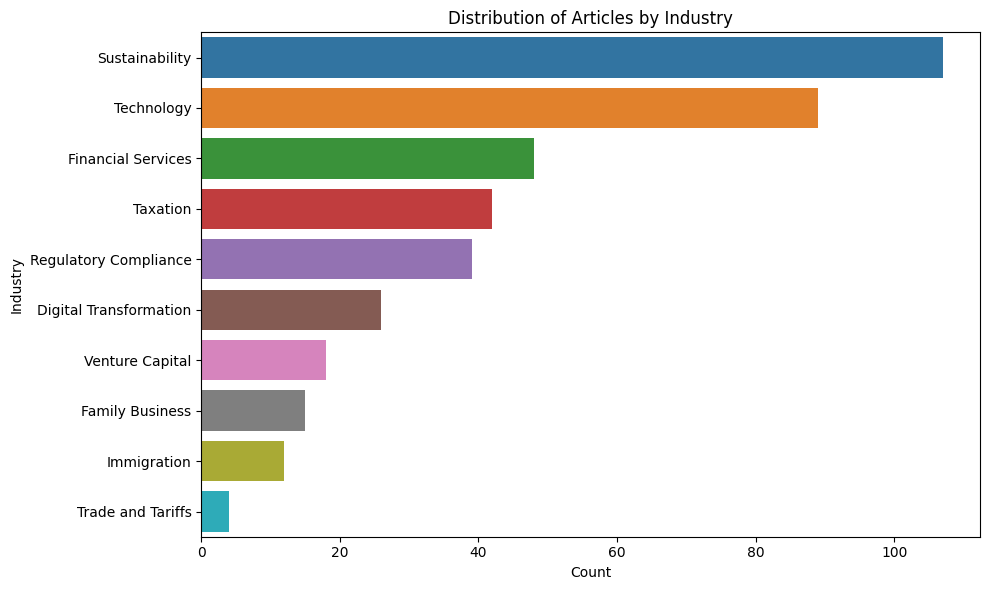

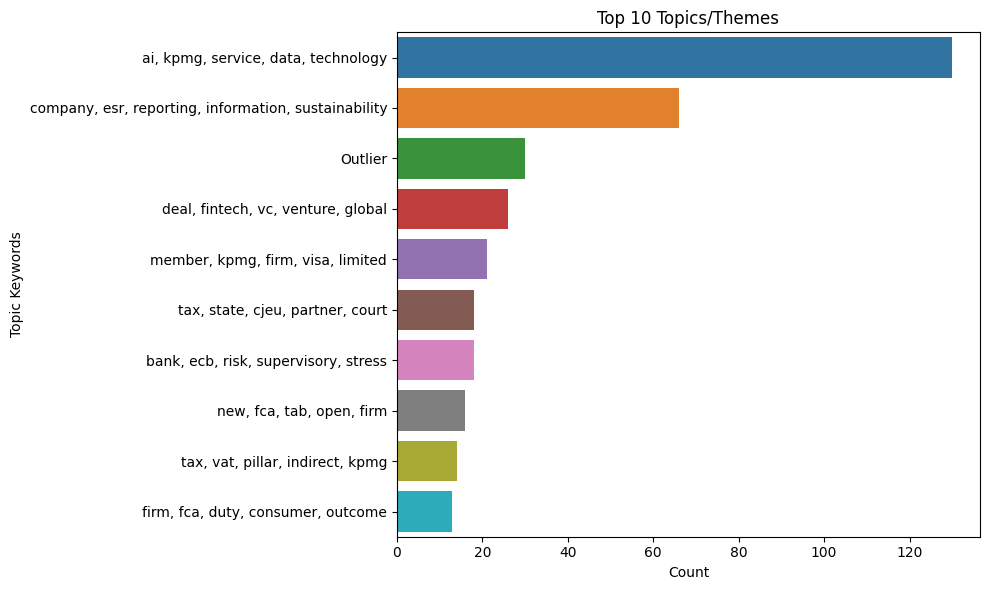

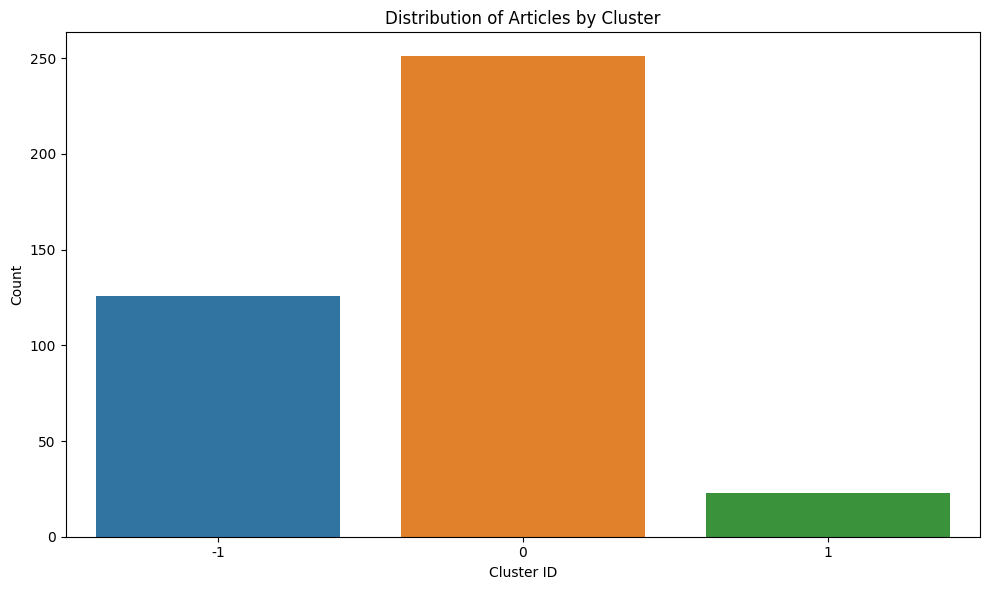

Final Output and Visualizations Complete:
Total Articles Processed: 400

Industry Distribution:
industry
Sustainability            107
Technology                 89
Financial Services         48
Taxation                   42
Regulatory Compliance      39
Digital Transformation     26
Venture Capital            18
Family Business            15
Immigration                12
Trade and Tariffs           4
Name: count, dtype: int64

Top 10 Topic Keywords:
topic_keywords
ai, kpmg, service, data, technology                     130
company, esr, reporting, information, sustainability     66
Outlier                                                  30
deal, fintech, vc, venture, global                       26
member, kpmg, firm, visa, limited                        21
tax, state, cjeu, partner, court                         18
bank, ecb, risk, supervisory, stress                     18
new, fca, tab, open, firm                                16
tax, vat, pillar, indirect, kpmg                  

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/kaggle/working/clustered_kpmg_data.csv')

output_df = df[[
    'artifact_id', 'title', 'url', 'industry', 'topic', 'topic_keywords', 'cluster', 'cleaned_text'
]]

output_df.to_csv('/kaggle/working/processed_kpmg_data.csv', index=False)

# Visualization 1: Industry Distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='industry', data=df, order=df['industry'].value_counts().index)
plt.title('Distribution of Articles by Industry')
plt.xlabel('Count')
plt.ylabel('Industry')
plt.tight_layout()
plt.savefig('/kaggle/working/industry_distribution.png')
plt.show()
plt.close()

# Visualization 2: Topic Distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='topic_keywords', data=df, order=df['topic_keywords'].value_counts().index[:10])
plt.title('Top 10 Topics/Themes')
plt.xlabel('Count')
plt.ylabel('Topic Keywords')
plt.tight_layout()
plt.savefig('/kaggle/working/topic_distribution.png')
plt.show()
plt.close()

# Visualization 3: Cluster Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df)
plt.title('Distribution of Articles by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('/kaggle/working/cluster_distribution.png')
plt.show()
plt.close()

print("Final Output and Visualizations Complete:")
print(f"Total Articles Processed: {len(df)}")
print("\nIndustry Distribution:")
print(df['industry'].value_counts())
print("\nTop 10 Topic Keywords:")
print(df['topic_keywords'].value_counts().head(10))
print("\nCluster Distribution:")
print(df['cluster'].value_counts())